In [1]:
import numpy as np
import pandas as pd
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("WineQT.csv")
print(df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  ...  sulphates  alcohol  quality  Id
0            7.4              0.70         0.00             1.9  ...       0.56      9.4        5   0
1            7.8              0.88         0.00             2.6  ...       0.68      9.8        5   1
2            7.8              0.76         0.04             2.3  ...       0.65      9.8        5   2
3           11.2              0.28         0.56             1.9  ...       0.58      9.8        6   3
4            7.4              0.70         0.00             1.9  ...       0.56      9.4        5   4

[5 rows x 13 columns]


Let’s explore the type of data present in each of the columns present in the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


Now we’ll explore the descriptive statistical measures of the dataset.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1143.0,8.311111,1.747595,4.60000,7.10000,7.90000,9.100000,15.90000
volatile acidity,1143.0,0.531339,0.179633,0.12000,0.39250,0.52000,0.640000,1.58000
citric acid,1143.0,0.268364,0.196686,0.00000,0.09000,0.25000,0.420000,1.00000
residual sugar,1143.0,2.532152,1.355917,0.90000,1.90000,2.20000,2.600000,15.50000
chlorides,1143.0,0.086933,0.047267,0.01200,0.07000,0.07900,0.090000,0.61100
free sulfur dioxide,1143.0,15.615486,10.250486,1.00000,7.00000,13.00000,21.000000,68.00000
total sulfur dioxide,1143.0,45.914698,32.782130,6.00000,21.00000,37.00000,61.000000,289.00000
density,1143.0,0.996730,0.001925,0.99007,0.99557,0.99668,0.997845,1.00369
pH,1143.0,3.311015,0.156664,2.74000,3.20500,3.31000,3.400000,4.01000
sulphates,1143.0,0.657708,0.170399,0.33000,0.55000,0.62000,0.730000,2.00000


# Exploratory Data Analysis

EDA is an approach to analysing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations.  Now let’s check the number of null values in the dataset columns wise.

In [6]:
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


Let’s impute the missing values by means as the data present in the different columns are continuous values.

In [7]:
for col in df.columns:
  if df[col].isnull().sum() > 0:
    df[col] = df [col].fillna(df[col].mean())

df.isnull().sum().sum()

0

Let’s draw the histogram to visualise the distribution of the data with continuous values in the columns of the dataset.

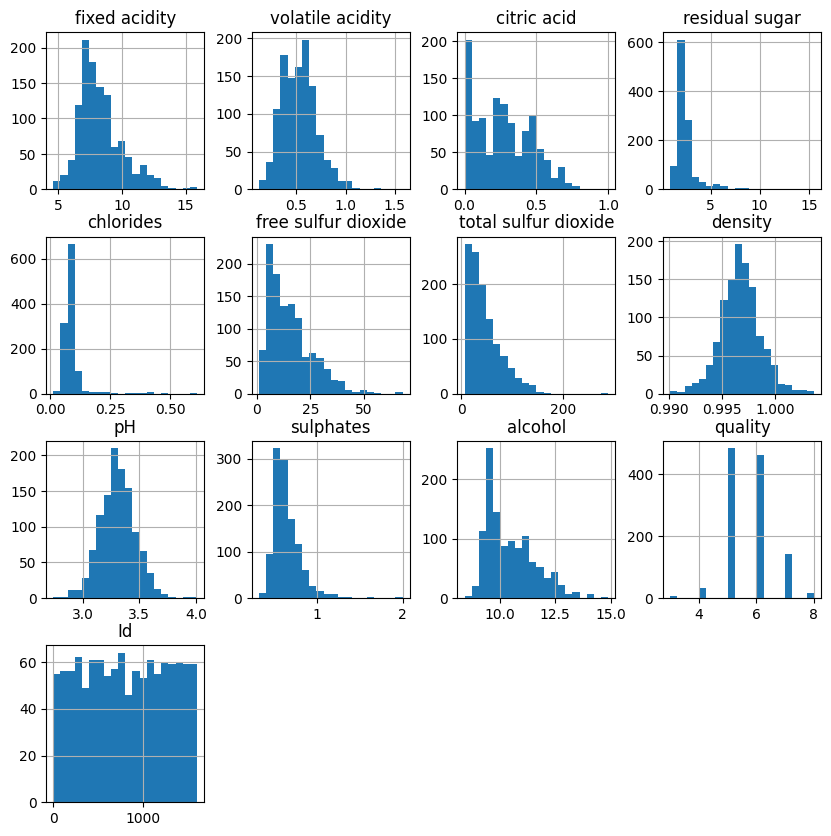

In [10]:
import matplotlib.pyplot as plt # Import the pyplot module and alias it as plt

df.hist(bins=20, figsize=(10, 10))
plt.show()

Now let’s draw the count plot to visualise the number data for each quality of wine.

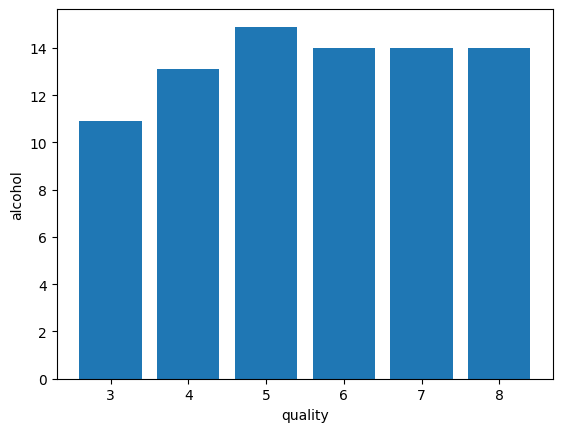

In [11]:
plt.bar(df['quality'], df['alcohol'])
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.show()

There are times the data provided to us contains redundant features they do not help with increasing the model’s performance that is why we remove them before using them to train our model.

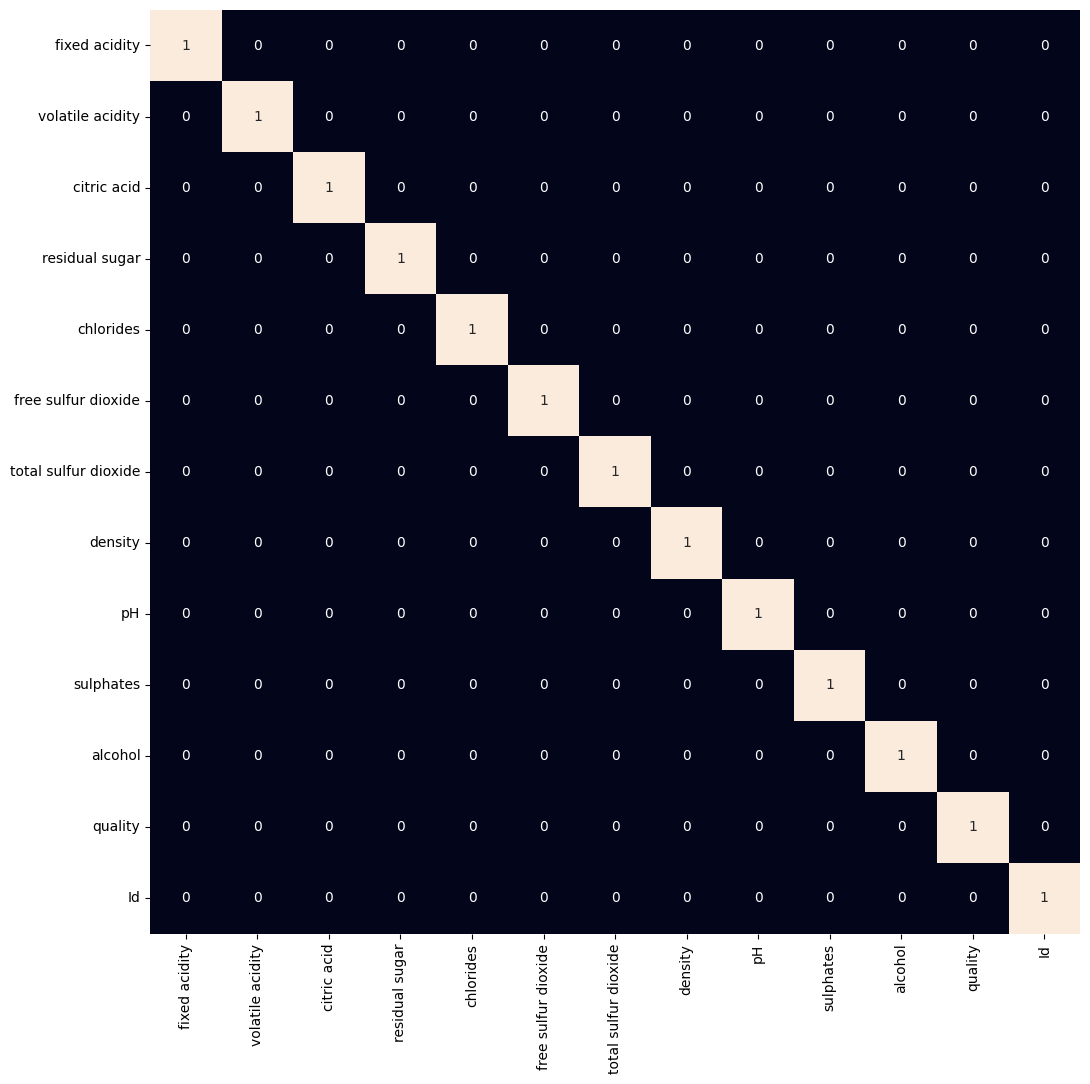

In [12]:
plt.figure(figsize=(12, 12))
sb.heatmap(df.corr() > 0.7, annot=True, cbar=False)
plt.show()

From the above heat map we can conclude that the ‘total sulphur dioxide’ and ‘free sulphur dioxide‘ are highly correlated features so, we will remove them.

In [13]:
df = df.drop('total sulfur dioxide', axis=1)

# Model Development

Let’s prepare our data for training and splitting it into training and validation data so, that we can select which model’s performance is best as per the use case. We will train some of the state of the art machine learning classification models and then select best out of them using validation data.

In [15]:
df['best quality'] = [1 if x > 5 else 0 for x in df.quality]

We have a column with object data type as well let’s replace it with the 0 and 1 as there are only two categories.

In [17]:
df.replace({'white': 1, 'red': 0}, inplace=True)

After segregating features and the target variable from the dataset we will split it into 80:20 ratio for model selection.

In [19]:
features = df.drop(['quality', 'best quality'], axis=1)
target = df['best quality']

xtrain, xtest, ytrain, ytest = train_test_split(
    features, target, test_size=0.2, random_state=40)

xtrain.shape, xtest.shape

((914, 11), (229, 11))

Normalising the data before training help us to achieve stable and fast training of the model.

In [20]:
norm = MinMaxScaler()
xtrain = norm.fit_transform(xtrain)
xtest = norm.transform(xtest)

As the data has been prepared completely let’s train some state of the art machine learning model on it.

In [21]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf')]

for i in range(3):
    models[i].fit(xtrain, ytrain)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(ytrain, models[i].predict(xtrain)))
    print('Validation Accuracy : ', metrics.roc_auc_score(
        ytest, models[i].predict(xtest)))
    print()

LogisticRegression() : 
Training Accuracy :  0.7546950559364851
Validation Accuracy :  0.7255154639175256

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.8022102467978757

SVC() : 
Training Accuracy :  0.7648213641284736
Validation Accu

# Model Evaluation

From the above accuracies we can say that Logistic Regression and SVC() classifier performing better on the validation data with less difference between the validation and training data. Let’s plot the confusion matrix as well for the validation data using the Logistic Regression model.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


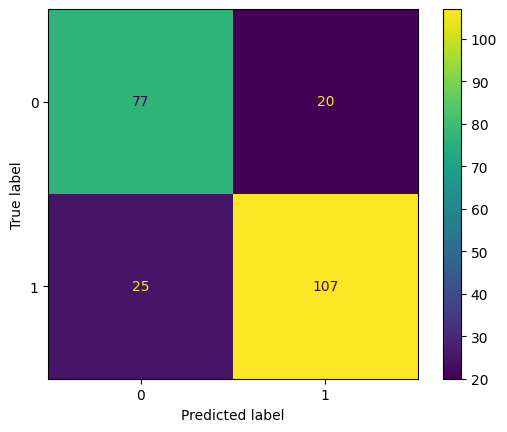

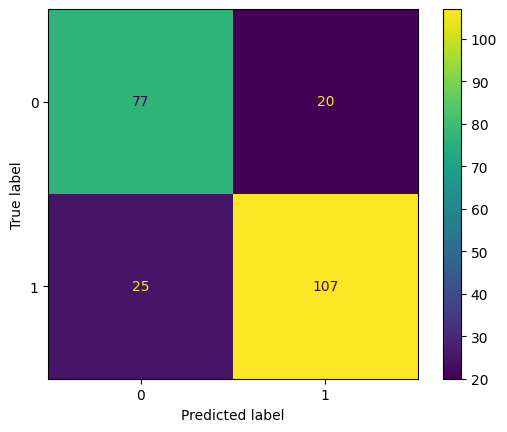

In [25]:
!pip install scikit-learn --upgrade # Make sure scikit-learn is up-to-date

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

# Assuming 'models' and other variables are already defined

disp = ConfusionMatrixDisplay.from_estimator(models[1], xtest, ytest)
disp.plot()
plt.show()

Let’s also print the classification report for the best performing model.

In [26]:
print(metrics.classification_report(ytest,models[1].predict(xtest)))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77        97
           1       0.84      0.81      0.83       132

    accuracy                           0.80       229
   macro avg       0.80      0.80      0.80       229
weighted avg       0.81      0.80      0.80       229

